In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from IPython.display import clear_output
from keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler

import segmentation_utils as su

2021-08-16 11:41:47.955360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


In [2]:
TILE_SIZE = 512
DOWNSAMPLE = 10

IMG_PATH = './tile_database/'+str(TILE_SIZE)+'_useful_images/'
MASK_PATH = './tile_database/'+str(TILE_SIZE)+'_useful_masks/'
print('Reading images from:', IMG_PATH)
print('Reading masks from:', MASK_PATH)
print('Used downsample for image generation:', DOWNSAMPLE)

BATCH_SIZE = 32
VAL_SPLIT = 0.2

CLASSES = {0 : 'background',
           1 : 'Mucosa',
           2 : 'Linfocitos',
           3 : 'Submucosa',
           4 : 'Muscular',
           5 : 'Subserosa',
          }
NUM_CLASSES = len(CLASSES)
BACKBONE = 'resnet34'

Reading images from: ./tile_database/512_useful_images/
Reading masks from: ./tile_database/512_useful_masks/
Used downsample for image generation: 10


## Get generators

In [3]:
scaler = MinMaxScaler()
preprocess_input = sm.get_preprocessing(BACKBONE)

#This function must be adapted for the used masks 
def preprocess_data(img, mask):
    #img = (img.astype('float32')) / 255.
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...

    #set mask colors as labels, notice coherente with the CLASS dict        
    mask=np.where(mask==225, 1, mask) #mucosa=1      #backgroud=0
    mask=np.where(mask==178, 2, mask) #linfocitos=2
    mask=np.where(mask==96,  3, mask) #submucosa=3
    mask=np.where(mask==131, 4, mask) #muscular=4
    mask=np.where(mask==105, 5, mask) #subserosa=5
    #Transform 1 channel labels to hot encoded
    mask = tf.keras.utils.to_categorical(mask, num_classes=NUM_CLASSES)
    return (img, mask)

# Get the generators
########### HAY QUE ADAPTAR LA FUNCION PARA LOS NUEVOS PATHS #########
train_generator=su.get_generator_from_directory(IMG_PATH, MASK_PATH, size=TILE_SIZE, mode='training',
                                                preprocess_function=preprocess_data, 
                                                augmentation=True, val_split=VAL_SPLIT, batch_size=BATCH_SIZE)
# Validation data should never be augmented
val_generator=su.get_generator_from_directory(IMG_PATH, MASK_PATH, size=TILE_SIZE, mode='validation', 
                                              preprocess_function=preprocess_data, 
                                              augmentation=False, val_split=VAL_SPLIT, batch_size=BATCH_SIZE)

# Check loaded images

Found 19611 images belonging to 1 classes.
Found 19611 images belonging to 1 classes.
Found 4902 images belonging to 1 classes.
Found 4902 images belonging to 1 classes.
Images is shape (32, 512, 512, 3)
Masks is shape (32, 512, 512, 6) and has values [0. 1.]
Masks modified for plotting 6 classes


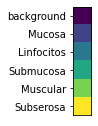

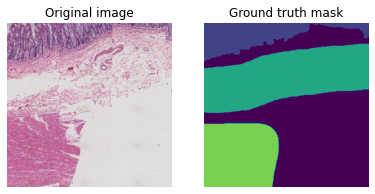

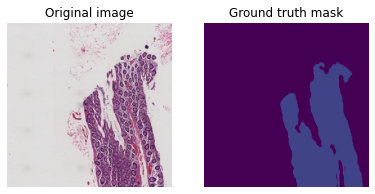

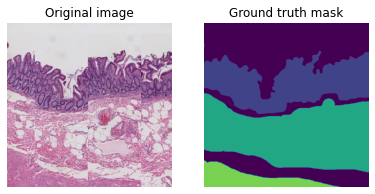

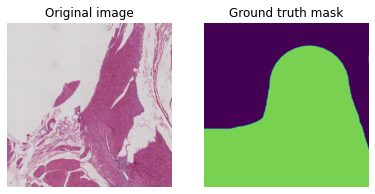

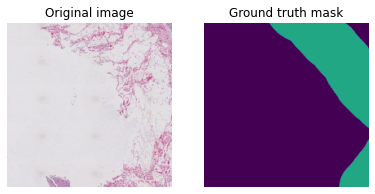

In [4]:
images, masks = train_generator.__next__()
val_images, val_masks = val_generator.__next__()

#print('Detected', len(images), 'images for training and', len(val_images), 'images for validation')
print('Images is shape', images.shape)
print('Masks is shape', masks.shape, 'and has values', np.unique(masks))

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
su.plot_legend(CLASSES)
su.plot_mask(images, one_channel_masks, num_plots=5)


## Prepare U-net model

In [5]:
# without these lines segmentation_models raises an error
sm.set_framework('tf.keras')
sm.framework()

#class_weights = [0.21, 2.60, 2.93, 2.52, 69.97, 5.36]
class_weights = [0.22, 2.69, 2.85, 2.39, 109.98, 3.91]
#class_weights = su.get_class_weights(TRAIN_PATH+'masks/img')
#print('Class weights:', class_weights)

dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS = dice_loss + (1 * focal_loss)
METRICS = metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet',
                input_shape=(TILE_SIZE, TILE_SIZE, 3),
                classes=NUM_CLASSES, 
                activation='softmax',
                #encoder_freeze=True
               )

OPTIMIZER = tf.keras.optimizers.Adam(0.0001)
model.compile(OPTIMIZER, 
              #loss=TOTAL_LOSS,
              loss=sm.losses.categorical_focal_jaccard_loss,
              metrics=METRICS)
#model.summary()    #print the model structure


# This class is used by model.fet to print a prediction at the end of every epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        images, masks = val_generator.__next__()
        predictions = model.predict(images[0:5])
        one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
        one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel
        su.plot_prediction(images, one_channel_masks, one_channel_predictions)


2021-08-16 11:42:05.617041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 11:42:13.802851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-16 11:42:13.802927: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 11:42:13.841238: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 11:42:13.841364: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-16 11:42:13.852838: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

## Train model


Sample Prediction after epoch 6

Masks modified for plotting 6 classes


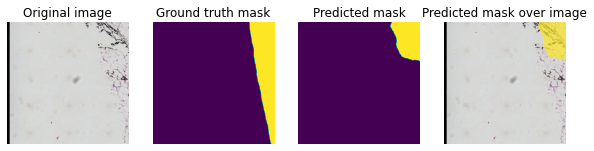

Epoch 7/200
612/612 [==============================] - ETA: 0s - loss: 0.1194 - iou_score: 0.8952 - f1-score: 0.9404

In [ ]:
import os
num_images = len(os.listdir(IMG_PATH+'img/'))

train_steps = int(num_images*(1-VAL_SPLIT)) // BATCH_SIZE
val_steps = int(num_images*VAL_SPLIT) // BATCH_SIZE
print('Num of images:', num_images, 'Train steps:', train_steps, 'Validation steps:', val_steps)

history = model.fit(train_generator,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    callbacks=[DisplayCallback()]
                   )
model_name = './resources/tiled_unet_d'+str(DOWNSAMPLE)+'_t'+str(TILE_SIZE)+'.hdf5'
print('Saving model to:', model_name)
model.save(model_name)

## Evaluate model

In [ ]:
#import pandas as pd
#hist_df = pd.DataFrame(history.history) 
#hist_csv_file = 'history_unet_50epochs.csv'
#with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)
    
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

max_iou = max(val_acc)
print ("Maximum accuracy reached: ", max_iou)
max_index = val_acc.index(max_iou)
print("Maximum accuracy reached at epoch: ",max_index+1)

In [ ]:
test_images, test_masks = val_generator.__next__()
prediction=model.predict(test_images)

test_masks = np.argmax(test_masks, axis=3) #from hot encoded to 1 channel
prediction=np.argmax(prediction, axis=3)

IOU = MeanIoU(num_classes=NUM_CLASSES)  
#compare groun truth and predicted masks
IOU.update_state(test_masks, prediction)

#calculate I0U for each class...
values = np.array(IOU.get_weights()).reshape(NUM_CLASSES, NUM_CLASSES)

#IoU = true positive / (true positive +
#                       false poitives (same row) +
#                       false negatives (same column))
class0_IoU = values[0,0] / (values[0,0] +
                            values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] +
                            values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])

class1_IoU = values[1,1] / (values[1,1] +
                            values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] +
                            values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])

class2_IoU = values[2,2] / (values[2,2] +
                            values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] +
                            values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])

class3_IoU = values[3,3] / (values[3,3] +
                            values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] +
                            values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])

class4_IoU = values[4,4] / (values[4,4] +
                            values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] +
                            values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])

class5_IoU = values[5,5] / (values[5,5] +
                            values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] +
                            values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])


print("Mean IoU using Unet =", IOU.result().numpy())
print('IoU for',CLASSES[0],'is:', class0_IoU)
print('IoU for',CLASSES[1],'is:', class1_IoU)
print('IoU for',CLASSES[2],'is:', class2_IoU)
print('IoU for',CLASSES[3],'is:', class3_IoU)
print('IoU for',CLASSES[4],'is:', class4_IoU)
print('IoU for',CLASSES[5],'is:', class5_IoU)
with np.printoptions(suppress=True):
    print('\n', values)

#with np.printoptions(threshold=np.inf):
#    print(test_masks[0])

su.plot_prediction(test_images, test_masks, prediction)

## Plots tests

In [ ]:
from patchify import unpatchify

STEP = int(TILE_SIZE/4)

images = su.get_image_tiles('../../DB/test/images/img/', TILE_SIZE, step=STEP)
no_cat_masks = su.get_mask_tiles('../../DB/test/masks/img/', TILE_SIZE, step=STEP)

print('\njust readed')
print(images.shape)
print(no_cat_masks.shape, np.unique(no_cat_masks))

images, masks = preprocess_data(images, no_cat_masks)
predictions = model.predict(images)

print('\npreprocessed')
print(images.shape)
print(masks.shape, np.unique(masks))
print(predictions.shape, np.unique(predictions))

one_channel_masks = np.argmax(masks, axis=3) #hot encoded to 1 channel
one_channel_predictions = np.argmax(predictions, axis=3) #hot encoded to 1 channel

print('\nargmax')
print(images.shape)
print(one_channel_masks.shape, np.unique(one_channel_masks))
print(one_channel_predictions.shape, np.unique(one_channel_predictions))

su.plot_prediction(images, one_channel_masks, one_channel_predictions, num_plots=5)

In [ ]:
import cv2
from smooth_tiled_predictions import predict_img_with_smooth_windowing
from keras.models import load_model

TILE_SIZE = 256
NUM_CLASSES = 6
BACKBONE = 'resnet34'

scaler = MinMaxScaler()
preprocess_input = sm.get_preprocessing(BACKBONE)

# Same function as training data loading
def preprocess_data(img, mask):
    #img = (img.astype('float32')) / 255.
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...

    #set mask colors as labels, notice coherente with the CLASS dict        
    mask=np.where(mask==225, 1, mask) #mucosa=1      #backgroud=0
    mask=np.where(mask==178, 2, mask) #linfocitos=2
    mask=np.where(mask==96,  3, mask) #submucosa=3
    mask=np.where(mask==131, 4, mask) #muscular=4
    mask=np.where(mask==105, 5, mask) #subserosa=5
    #Transform 1 channel labels to hot encoded
    mask = tf.keras.utils.to_categorical(mask, num_classes=NUM_CLASSES)
    return (img, mask)


model = load_model('./resources/tiled_unet_d40_t256.hdf5', compile=False)
img = cv2.imread('../../DB/qupath_images/images/img/10-1960 HEN.jpg') #1960
#img = cv2.imread('database/images/img/10-1960 HEN.jpg') #1960
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('../../DB/qupath_images/masks/img/10-1960 HEN.png', 0)
img, mask = preprocess_data(img, mask)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
smooth_prediction = predict_img_with_smooth_windowing(
    img,
    window_size=TILE_SIZE,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=NUM_CLASSES,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

mask = np.argmax(mask, axis=2)  #hot encoded to 1 channel
final_prediction = np.argmax(smooth_prediction, axis=2)  #hot encoded to 1 channel

imgs = np.expand_dims(img, axis=0)  #convert to list
masks = np.expand_dims(mask, axis=0)
final_predictions = np.expand_dims(final_prediction, axis=0)

su.plot_prediction(imgs, masks, final_predictions, size=20)


In [ ]:
'''
# Place all pixel values for colour coherence
for j in range(NUM_CLASSES):
    mask[0,j]=j
    final_prediction[0,j]=j
    
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.axis('off')
plt.title('Ground truth mask')
plt.imshow(mask)
plt.subplot(223)
plt.axis('off')
plt. title('Predicted mask over image')
plt.imshow(img)
no_background_predictions = np.ma.masked_where(final_prediction == 0, final_prediction) # remove background(0) from prediction
plt.imshow(no_background_predictions, cmap=cmap, alpha=0.7)
plt.subplot(224)
plt.axis('off')
plt.title('Smooth predicted mask')
plt.imshow(final_prediction)
plt.tight_layout()
'''